In [1]:
import sqlite3 as sl
import pandas as pd
import random
import string

# **ЗАДАНИЕ 1**

In [66]:
#create database
database = sl.connect('sqlexerciers.db')

Требуется написать SQL запрос, который к каждой транзакции добавит: 
 * Дату первой сделки покупателя.
 * Дату предыдущей сделки покупателя.
 * Покажет общее количество товаров, купленных покупателем. Присвоить всем сделкам покупателя / продавца порядковый номер.

In [77]:
pd.read_sql_query(
    """
    SELECT sales_id,
           ROW_NUMBER() OVER(PARTITION BY buyer_id ORDER BY date) as order_number,
           SUM(qty) OVER(PARTITION BY buyer_id) as sum_qty,
           LAG(date) OVER (PARTITION BY buyer_id ORDER BY date) as previous_transaction_date,
           MIN(date) OVER (PARTITION BY buyer_id ORDER BY date ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) as first_transaction_date
        
    FROM total_sales
   """, 
    database
)

,sales_id,order_number,sum_qty,previous_transaction_date,first_transaction_date
0,40494,1,40,None,12.04.2022
1,34489,2,40,12.04.2022,12.04.2022
2,83056,1,80,None,06.07.2022
3,36044,2,80,06.07.2022,06.07.2022
4,85754,1,100,None,05.04.2022
5,25651,1,110,None,11.06.2022
6,96498,2,110,11.06.2022,11.06.2022


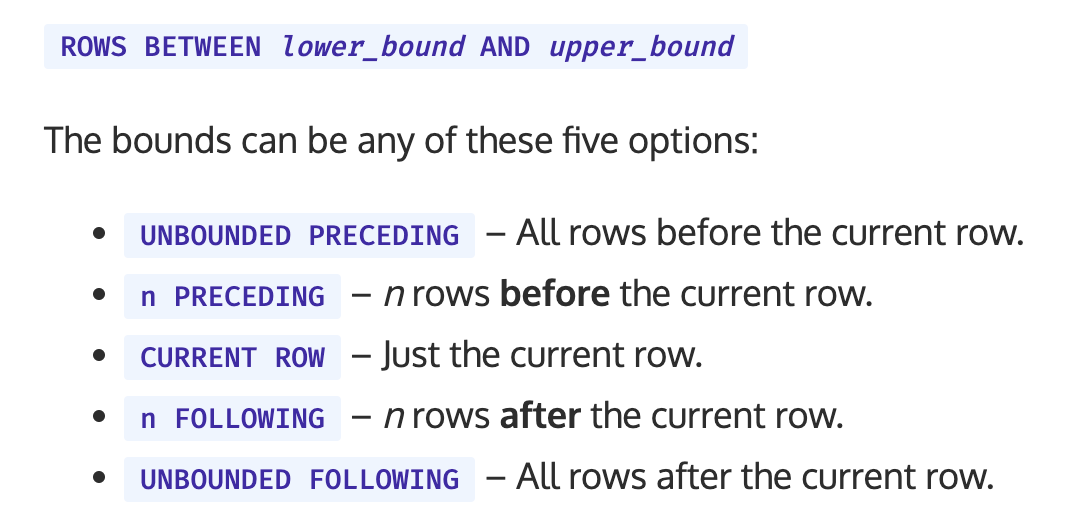

# **ЗАДАНИЕ 2**

## 2.1

In [2]:
con = sl.connect('exercise2.db')

In [10]:
pd.read_sql_query("""SELECT *
                     FROM stores""", con)

,store_id,store_nm
0,277,dtKBngEzRG
1,320,qAaFQgyjSp
2,324,uVuSmGJgOe
3,391,hgmlPkVNMp
4,500,fhuLVOSTsQ
5,743,dsuShwywEa
6,788,VGBdSRSLTV
7,837,kgdCSLMLXB
8,959,OxWEtheYzN
9,987,xQFJRRGYWc


In [13]:
pd.read_sql_query("""SELECT *
                     FROM customers""", con)

,customer_id,customer_nm
0,199,xJdJypRMWX
1,391,HjZjdjHlUz
2,695,UXsHuDkxrg
3,696,hVNOBABbYG
4,709,jcxRxQvmDG
5,769,MDeTajAPbG
6,779,LChyLJOMcn
7,849,eCFkttQFEk
8,895,sSiBZBePlo
9,899,detLHSRWno


In [20]:
pd.read_sql_query("""SELECT *
                     FROM sales""", con)

,sales_id,store_id,customer_id,dt,amt
0,12,500,779,13.05.2022,56
1,15,796,663,06.08.2022,65
2,23,277,199,01.01.2022,13
3,33,277,199,02.02.2022,15
4,43,562,391,03.02.2022,17
5,65,712,695,07.03.2022,56
6,67,500,779,03.02.1022,76
7,73,277,199,08.05.2022,89
8,76,143,565,05.06.2022,87
9,78,959,979,17.02.1022,51


**Для каждого покупателя найдите магазин, в котором он совершил наибольшее количество покупок**

В данном случае увидим только store_id и customer_id

In [43]:
pd.read_sql_query(""" SELECT customer_id,
                             store_id,
                             MAX(count) as amt_purchases
                             
                      FROM (SELECT customer_id,
                                       store_id,
                                       COUNT(sales_id) as count
                                FROM sales  
                                GROUP BY customer_id, store_id) 
                      GROUP BY customer_id, store_id""", con)

,customer_id,store_id,amt_purchases
0,199,277,3
1,391,562,1
2,565,143,1
3,663,796,1
4,695,712,1
5,779,500,2
6,979,959,1


Если хотим узнать название магазина и покупателя.

In [46]:
pd.read_sql_query(""" SELECT m.customer_id,
                             m.store_id,
                             MAX(count) as amt_purchases,
                             s.store_nm,
                             c.customer_nm
                             
                      FROM (SELECT customer_id,
                                       store_id,
                                       COUNT(sales_id) as count
                                FROM sales  
                                GROUP BY customer_id, store_id) as m
                      JOIN stores as s on m.store_id = s.store_id
                      JOIN customers as c on c.customer_id = m.customer_id
                      GROUP BY m.customer_id, s.store_id""", con)

,customer_id,store_id,amt_purchases,store_nm,customer_nm
0,199,277,3,dtKBngEzRG,xJdJypRMWX
1,779,500,2,fhuLVOSTsQ,LChyLJOMcn


## 2.2

Найдите всех покупателей, которые в каждом полном месяце этого года совершали не менее 3 покупок

Вопрос: Если месяц незакончился мы должны его исключить? Можно исключить текущий месяц на момент которого деляется выгрузка данных, так как он вероятно будет неполный.

In [63]:
pd.read_sql_query(""" SELECT s.customer_id,
                             c.customer_nm
                      FROM (SELECT  customer_id,
                                    strftime('%m', dt) as month,
                                    COUNT(sales_id) as count
                             FROM sales
                             WHERE strftime('%Y', dt) = '2022' 
                                   AND strftime('%m', dt) <> strftime('%m', 'now')
                             GROUP BY customer_id, month) as s
                      JOIN customers as c on c.customer_id = s.customer_id      
                      WHERE s.count > 3
                      GROUP BY c.customer_id""", con)

,customer_id,customer_nm


## 2.3

В схеме данных нет таблицы company или колонки в одной из таблиц. Поэтому представим что есть отдельная таблица company содержащая название компании, store_id.

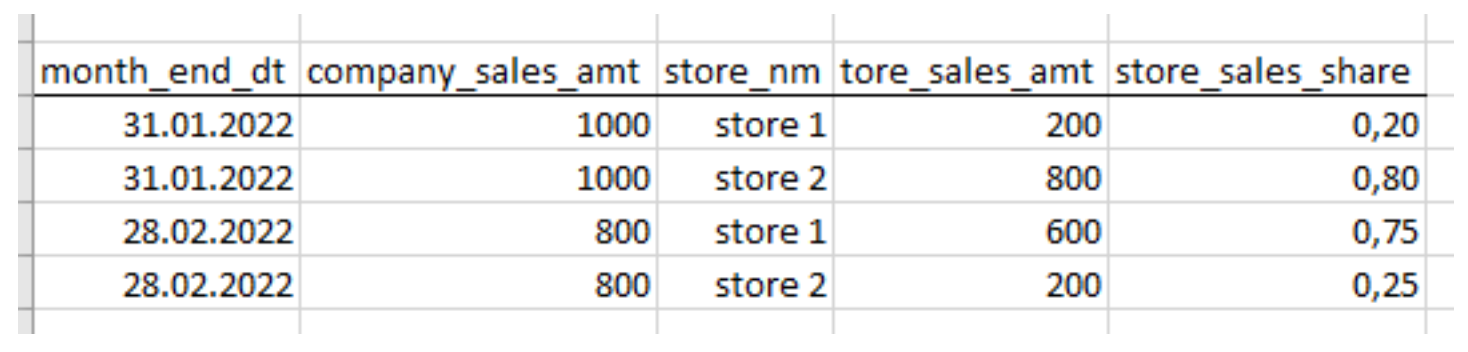

Вот здесь не совсем уверена.

In [ ]:
pd.read_sql_query(""" SELECT date(TRUNC(dt, 'MM'), '+1 month', '-1 day') as month_end_dt,
                             COUNT(s.sales_id) as store_sales_amt,
                             str.store_nm,
                             SUM(s.amt) as company_sales_amt,
                             COUNT(s.sales_id) / SUM(s.amt) as store_sales_share                            
                      FROM sales s
                      JOIN stores as str on s.store_id = str.store_id
                      JOIN company as c on c.store_id = s.store_id                                 
                      GROUP BY str.store_nm, c.company_nm """, con)

# **ЗАДАНИЕ 3**

## 3.1

Напишите SQL запрос, определяющий уникальные id абонентов, которые хоть раз звонили в роуминге за отчетный месяц.
Отчетный месяц может быть любой.

In [ ]:
pd.read_sql_query(""" SELECT DISTINCT id_abon
                      FROM calls
                      WHERE roaming = 1 AND strftime('%m', date) = 01
""", con)

## 3.2

В таблице **abnt** хранятся уникальные id всех абонентов, совершавших звонки за отчетный месяц.
В таблице **roam** хранятся уникальные id абонентов, которые были в роуминге за отчетный месяц.
Напишите SQL запрос, результатом которого будут все id абонентов, которые не были в роуминге в текущем месяце.

In [ ]:
pd.read_sql_query(""" SELECT id_abon
                      FROM abnt
                      WHERE id NOT IN (SELECT Id
                                       FROM roam)
""", con)

## 3.3

Напишите SQL запрос, который выведет всех абонентов с начислениями в домашней сети больше 0.
Начисления в домашней сети= все начисления (abnt.clc) - начисления в роуминге (roam.clc).

In [80]:
con = sl.connect('exercise3.db')

In [89]:
pd.read_sql_query(""" SELECT a.abnt_id
                      FROM abnt as a
                      LEFT JOIN roam as r on a.abnt_id = r.abnt_id
                      WHERE (a.clc - r.clc) > 0
""", con)

,abnt_id
0,23
1,43


## 3.4

Используя данные таблицы calls, выведите id всех абонентов, у которых было
больше 5 звонков в роуминге.

In [ ]:
pd.read_sql_query(""" SELECT id_abon
                      FROM calls
                      WHERE roaming = 1
                      GROUP BY id_abon
                      HAVING COUNT(roaming) > 5
""")

## 3.5

Используя данные таблицы calls, выведите периоды нахождения абонентов в
роуминге. Время пребывания в роуминге определяется непрерывной последовательностью звонков в роуминге.

Как я поняла задание: если человек был в роуминге 01.02, 02.02 и 03.02 то он непрерывно был в роуминге 3 дня. Следовательно нужно найти сколько дней пользователь непрерывно был в роуминге. Но тут у меня есть вопросы.

In [114]:
pd.read_sql_query(""" WITH roaming_calls AS (
                                    SELECT *,
                                           ROW_NUMBER() OVER (PARTITION BY id_abon ORDER BY date) AS rn
                                    FROM calls
                                    WHERE roaming = 1
                                ),
                           roam_dur AS (SELECT id_abon,
                                               MIN(date) as mindate,
                                               MAX(date) as maxdate,
                                               (rn-ROW_NUMBER() OVER (PARTITION BY id_abon ORDER BY date)) as grp
                                        FROM roaming_calls
                                        GROUP BY id_abon           
                           )     
                                
                        SELECT id_abon,
                               mindate,
                               maxdate,
                               julianday(maxdate) - julianday(mindate) as duration_days
                      FROM roam_dur
                      ORDER BY id_abon
                      
""", con)

,id_abon,mindate,maxdate,duration_days
0,23,01.01.2022,02.01.2022,None
1,43,06.05.2022,06.05.2022,None
2,63,09.05.2022,09.05.2022,None


In [115]:
pd.read_sql_query(""" WITH roaming_calls AS (
                                    SELECT *,
                                           ROW_NUMBER() OVER (PARTITION BY id_abon ORDER BY date) AS rn
                                    FROM calls
                                    WHERE roaming = 1
                                )
                           SELECT id_abon,
                                  MIN(date) as mindate,
                                  MAX(date) as maxdate,
                                  (rn-ROW_NUMBER() OVER (PARTITION BY id_abon ORDER BY date)) as grp
                           FROM roaming_calls
                           GROUP BY id_abon           
                           """, con)

,id_abon,mindate,maxdate,grp
0,23,01.01.2022,02.01.2022,1
1,43,06.05.2022,06.05.2022,0
2,63,09.05.2022,09.05.2022,0


## **ЗAДАНИЕ 4**

In [ ]:
# connect to database
con = sl.connect('exercise4.db')

In [95]:
pd.read_sql_query("""SELECT *
                    FROM t2
                    LIMIT 3""", con)

,id,status
0,21968,выдан
1,42398,выдан
2,52183,выдан


In [96]:
# sql query which shows as all surname of clients who got a credit
query = """SELECT t1.id,
                  t1.surname
           FROM t1 INNER JOIN t2 ON t1.id = t2.id
           WHERE t2.status = 'выдан'
"""
pd.read_sql_query(query, con)

,id,surname
0,21968,Клипенко
1,42398,Санников
2,52183,Васильев
